### Introduction: Bayesian Linear Regression Project
In this notebook, we will implement a complete machine learning project, focusing on Bayesian Inference methods, in particular, Bayesian Linear Regression. We will go through the entire machine learning process, cleaning the data, exploring it to find trends, establishing a baseline model, evaluating several machine learning approaches for comparisons, implementing Bayesian Linear Regression, interpreting the results, and presenting the results. Let's get started!

### Dataset
We are using data on student grades collected from a Portuguese secondary (high) school. This data is from the UCI machine learning repository, a great collection of datasets for model testing. The data includes academic and personal characteristics of the students as well as final grades. The objective is to predict the final grade from the student information which makes this a supervised, regression task. We have a set of training data with known labels, and we want the model to learn a mapping from the features (explanatory variables) to the target (the label) in this case the final grade. It is a regression task because the final grade is a continuous value.

#### attached a link of dataset

### Exploratory Data Analysis

In [10]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(42)

 
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['font.size'] = 16
# matplotlib.rcParams['figure.figsize'] = (9, 9)

import seaborn as sns

from IPython.core.pylabtools import figsize

# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats

In [11]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy

In [12]:
# PyMC3 for Bayesian Inference
import pymc3 as pm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\ashupatel\AppData\Local\Continuum\anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Read in Data and Examine

In [13]:
pd.set_option('display.max_columns', None) 

# Read in dataframe
df = pd.read_csv('student-mat.csv')

# Filter out grades that were 0
df = df[~df['G3'].isin([0, 1])]

df = df.rename(columns={'G3': 'Grade'})

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


In [14]:
df.shape

(633, 33)

#### Describe for Numerical Columns

In [15]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
count,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000
mean,16.720379,2.519747,2.320695,1.563981,1.941548,0.206951,3.932070,3.169036,3.184834,1.489731,2.268562,3.527646,3.751975,11.503949,11.756714,12.205371
std,1.214044,1.133497,1.102284,0.750167,0.833284,0.579023,0.946411,1.047082,1.162014,0.912452,1.281776,1.448355,4.662003,2.682645,2.629715,2.656882
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.000000,5.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,12.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


#### Value Counts for Categorical Columns

In [16]:
# Print the value counts for categorical columns
for col in df.columns:
    if df[col].dtype == 'object':
        print('\nColumn Name:', col,)
        print(df[col].value_counts())


Column Name: school
GP    421
MS    212
Name: school, dtype: int64

Column Name: sex
F    376
M    257
Name: sex, dtype: int64

Column Name: address
U    446
R    187
Name: address, dtype: int64

Column Name: famsize
GT3    443
LE3    190
Name: famsize, dtype: int64

Column Name: Pstatus
T    555
A     78
Name: Pstatus, dtype: int64

Column Name: Mjob
other       249
services    135
at_home     131
teacher      70
health       48
Name: Mjob, dtype: int64

Column Name: Fjob
other       359
services    175
at_home      41
teacher      35
health       23
Name: Fjob, dtype: int64

Column Name: reason
course        279
home          146
reputation    141
other          67
Name: reason, dtype: int64

Column Name: guardian
mother    444
father    149
other      40
Name: guardian, dtype: int64

Column Name: schoolsup
no     566
yes     67
Name: schoolsup, dtype: int64

Column Name: famsup
yes    393
no     240
Name: famsup, dtype: int64

Column Name: paid
no     595
yes     38
Name: paid, dty

#### Distribution of Grades

In [17]:
df['Grade'].describe()

count    633.000000
mean      12.205371
std        2.656882
min        5.000000
25%       10.000000
50%       12.000000
75%       14.000000
max       19.000000
Name: Grade, dtype: float64

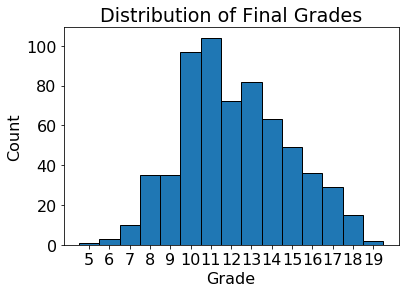

In [18]:
# Bar plot of grades
plt.bar(df['Grade'].value_counts().index, 
        df['Grade'].value_counts().values,
         fill = 'navy', edgecolor = 'k', width = 1)
plt.xlabel('Grade'); plt.ylabel('Count'); plt.title('Distribution of Final Grades');
plt.xticks(list(range(5, 20)));

In [19]:
print("Mean: ", df["Grade"].mean())
print("Median: ", df["Grade"].median())
print("Mode: ", df["Grade"].mode())
print("Skewnes: ", df["Grade"].skew())
print("Kurtosis: ", df["Grade"].kurtosis())

Mean:  12.205371248025276
Median:  12.0
Mode:  0    11
dtype: int64
Skewnes:  0.2288351356505017
Kurtosis:  -0.47282632188662355


The distribution is almost normal (slightly positively skewed).

#### Grade Distribution by Different Categorical Variables

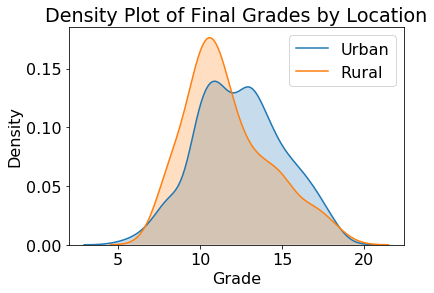

In [20]:
# Grade distribution by address
sns.kdeplot(df.loc[df['address'] == 'U', 'Grade'], label = 'Urban', shade = True)
sns.kdeplot(df.loc[df['address'] == 'R', 'Grade'], label = 'Rural', shade = True)
plt.xlabel('Grade'); plt.ylabel('Density'); plt.title('Density Plot of Final Grades by Location')
plt.show()

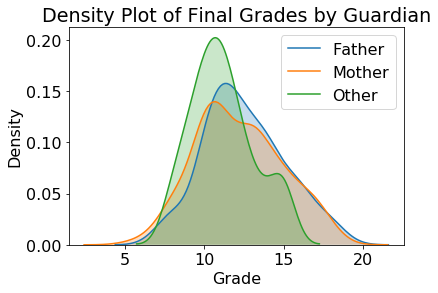

In [21]:
# Grade distribution by Guardian
sns.kdeplot(df.loc[df['guardian'] == 'father', 'Grade'], label = 'Father', shade = True)
sns.kdeplot(df.loc[df['guardian'] == 'mother', 'Grade'], label = 'Mother', shade = True)
sns.kdeplot(df.loc[df['guardian'] == 'other', 'Grade'], label = 'Other', shade = True)
plt.xlabel('Grade')
plt.ylabel('Density') 
plt.title('Density Plot of Final Grades by Guardian')
plt.show()

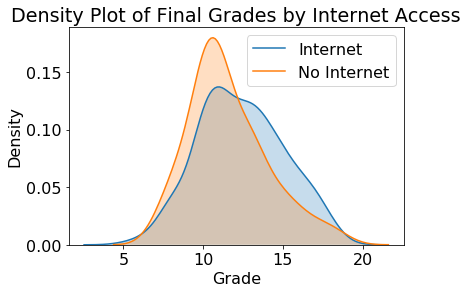

In [22]:
# Grade distribution by internet
sns.kdeplot(df.loc[df['internet'] == 'yes', 'Grade'], label = 'Internet', shade = True)
sns.kdeplot(df.loc[df['internet'] == 'no', 'Grade'], label = 'No Internet', shade = True)
plt.xlabel('Grade')
plt.ylabel('Density')
plt.title('Density Plot of Final Grades by Internet Access')
plt.show()

C:\Users\ashupatel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
C:\Users\ashupatel\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
C:\Users\ashupatel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/in

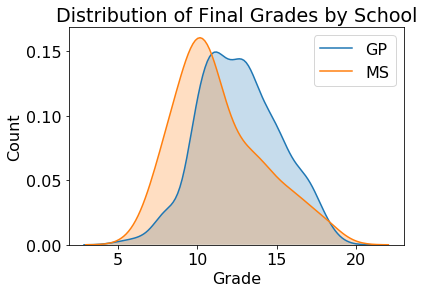

In [23]:
# Grade distribution by school
sns.kdeplot(df.ix[df['school'] == 'GP', 'Grade'], label = 'GP', shade = True)
sns.kdeplot(df.ix[df['school'] == 'MS', 'Grade'], label = 'MS', shade = True)
plt.xlabel('Grade')
plt.ylabel('Count')
plt.title('Distribution of Final Grades by School')
plt.show()

The location does not seem to have a substantial impact on the student grades and neither does the guardian, school, internet.

In [24]:
# Look at distribution of schools by address
schools = df.groupby(['school'])['address'].value_counts()
schools

school  address
GP      U          343
        R           78
MS      R          109
        U          103
Name: address, dtype: int64

#### Grade Percentiles

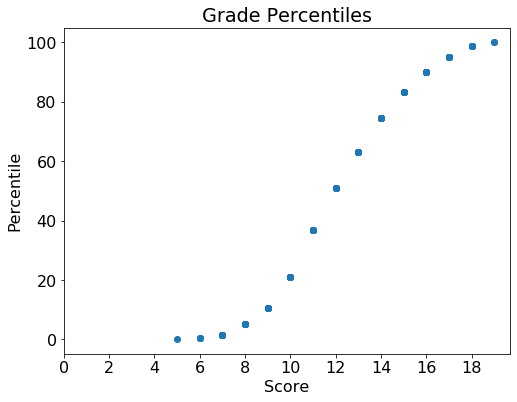

In [25]:
# Calculate percentile for grades
df['percentile'] = df['Grade'].apply(lambda x: percentileofscore(df['Grade'], x))

# Plot percentiles for grades
plt.figure(figsize = (8, 6))
plt.plot(df['Grade'], df['percentile'], 'o')
plt.xticks(range(0, 20, 2), range(0, 20, 2))
plt.xlabel('Score'); plt.ylabel('Percentile'); plt.title('Grade Percentiles');

In [26]:
print('50th percentile score:', np.min(df.loc[df['percentile'] > 50, 'Grade']))
print('Minimum Score needed for 90th percentile:', np.min(df.loc[df['percentile'] > 90, 'Grade']))

50th percentile score: 12
Minimum Score needed for 90th percentile: 17


### Variable Correlations with Final Grade
#### Numerical Correlations

In [27]:
# Correlations of numerical values
df.corr()['Grade'].sort_values()

failures     -0.384569
absences     -0.204230
Dalc         -0.196891
Walc         -0.178839
traveltime   -0.129654
goout        -0.111228
freetime     -0.105206
health       -0.096461
age          -0.042505
famrel        0.072888
Fedu          0.204392
studytime     0.249855
Medu          0.278690
G1            0.874777
G2            0.942691
percentile    0.985253
Grade         1.000000
Name: Grade, dtype: float64

1. Failures is the number of previous class failures and is negatively correlated with the grade.
2. Absences, the number of absences from school. This negative correlation indicates that as these variables increase, the final grade tends to decrease
3. On the other hand, both studytime, the amount of studying per week, and Medu (the mother’s level of education), are positively correlated with the grade.

#### Categorical Correlations using One-Hot Encoding

In [28]:
# Select only categorical variables
category_df = df.select_dtypes('object')

# One hot encode the variables
dummy_df = pd.get_dummies(category_df)

# Put the grade back in the dataframe
dummy_df['Grade'] = df['Grade']
dummy_df.head()

,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,Grade
0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0,11
1,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,11
2,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,1,1,0,12
3,1,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,14
4,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0,1,1,0,1,0,13


In [29]:
# Correlations in one-hot encoded dataframe
dummy_df.corr()['Grade'].sort_values()

higher_no           -0.343742
school_MS           -0.227632
Mjob_at_home        -0.158496
reason_course       -0.138195
internet_no         -0.131408
address_R           -0.128350
sex_M               -0.125755
guardian_other      -0.100802
schoolsup_yes       -0.098185
reason_other        -0.092382
activities_no       -0.078526
paid_yes            -0.067146
nursery_no          -0.056449
romantic_yes        -0.052050
Fjob_at_home        -0.049372
Fjob_services       -0.042497
Mjob_other          -0.035494
Fjob_other          -0.021292
famsize_GT3         -0.012957
guardian_mother     -0.008042
Pstatus_T           -0.001776
famsup_no           -0.001581
famsup_yes           0.001581
Pstatus_A            0.001776
Mjob_services        0.006210
famsize_LE3          0.012957
Fjob_health          0.026320
reason_home          0.046639
romantic_no          0.052050
nursery_yes          0.056449
guardian_father      0.066486
paid_no              0.067146
activities_yes       0.078526
Mjob_healt

1. higher_no represents the student does not want to go on to higher education and is negatively correlated with the grade with higher_yes indicating the student does want higher education and showing a positive correlation.
2. Mjob_at_home means the mother stays at home, and is negatively correlated with the grade.
3. Mjob_teacher indicates the mother teaches and has a positive correlation.

### Feature Selection
Let us select top 6 correlated feature for modeling.

In [30]:
# Takes in a dataframe, finds the most correlated variables with the
# grade and returns training and testing datasets
def format_data(df):
    # Targets are final grade of student
    labels = df['Grade']
    
    # Drop the school and the grades from features
    df = df.drop(columns=['school', 'G1', 'G2', 'percentile'])
    
    # One-Hot Encoding of Categorical Variables
    df = pd.get_dummies(df)
    
    # Find correlations with the Grade
    most_correlated = df.corr().abs()['Grade'].sort_values(ascending=False)
    
    # Maintain the top 6 most correlation features with Grade
    most_correlated = most_correlated[:8]
    
    df = df.loc[:, most_correlated.index]
    df = df.drop(columns = 'higher_no')
    
    # Split into training/testing sets with 25% split
    X_train, X_test, y_train, y_test = train_test_split(df, labels, 
                                                        test_size = 0.25,
                                                        random_state=42)
    
    return X_train, X_test, y_train, y_test

In [31]:
X_train, X_test, y_train, y_test = format_data(df)
X_train.head()

,Grade,failures,higher_yes,Medu,studytime,Fedu,absences
619,13,0,1,3,2,3,6
323,10,0,1,4,1,3,0
201,16,0,1,2,2,1,0
410,17,0,1,2,2,2,0
426,11,0,1,3,1,3,4


#### Rename Variables

In [32]:
# Rename variables in train and teste
X_train = X_train.rename(columns={'higher_yes': 'higher_edu', 
                                  'Medu': 'mother_edu',
                                  'Fedu': 'father_edu'})

X_test = X_test.rename(columns={'higher_yes': 'higher_edu', 
                                  'Medu': 'mother_edu',
                                  'Fedu': 'father_edu'})

In [33]:
X_train.head()

,Grade,failures,higher_edu,mother_edu,studytime,father_edu,absences
619,13,0,1,3,2,3,6
323,10,0,1,4,1,3,0
201,16,0,1,2,2,1,0
410,17,0,1,2,2,2,0
426,11,0,1,3,1,3,4


#### Pairs Plot of Selected Variables

C:\Users\ashupatel\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\ashupatel\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\Users\ashupatel\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\distributions.py:423: UserWarning: No contour levels were found within the data range.
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


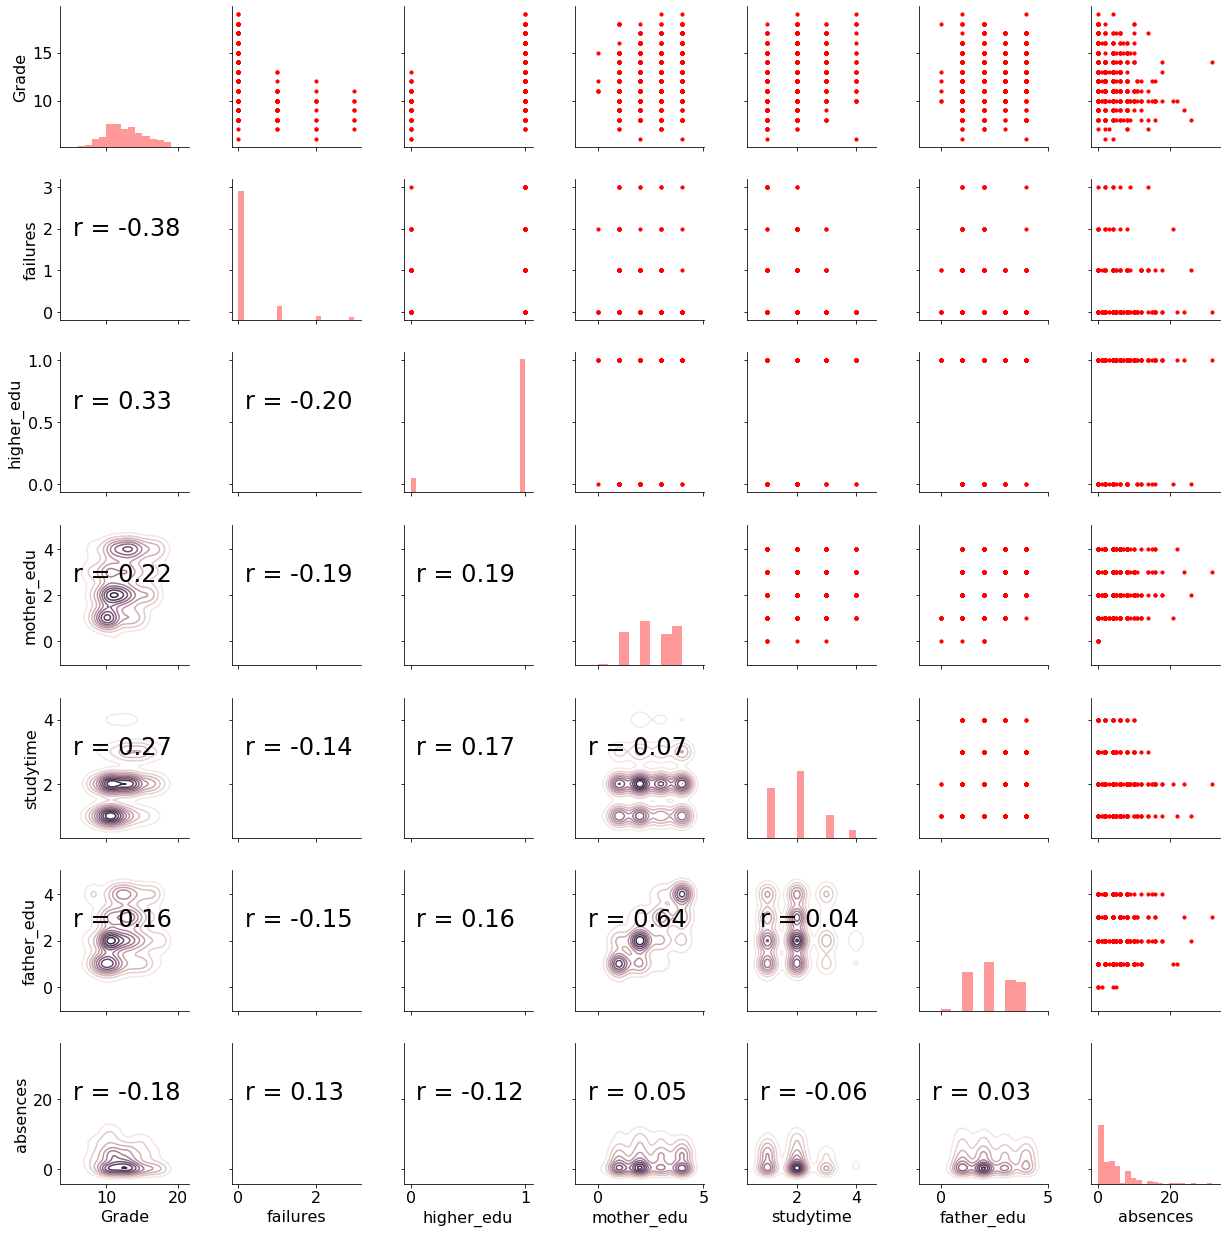

In [34]:
# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(X_train)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc)

Failure is most correlated with Grade.

#### Selected Variables Distribution by Relation to Median

In [35]:
# Create relation to the median grade column
X_plot = X_train.copy()
X_plot['relation_median'] = (X_plot['Grade'] >= 12)
X_plot['relation_median'] = X_plot['relation_median'].replace({True: 'above', False: 'below'})
X_plot = X_plot.drop(columns='Grade')

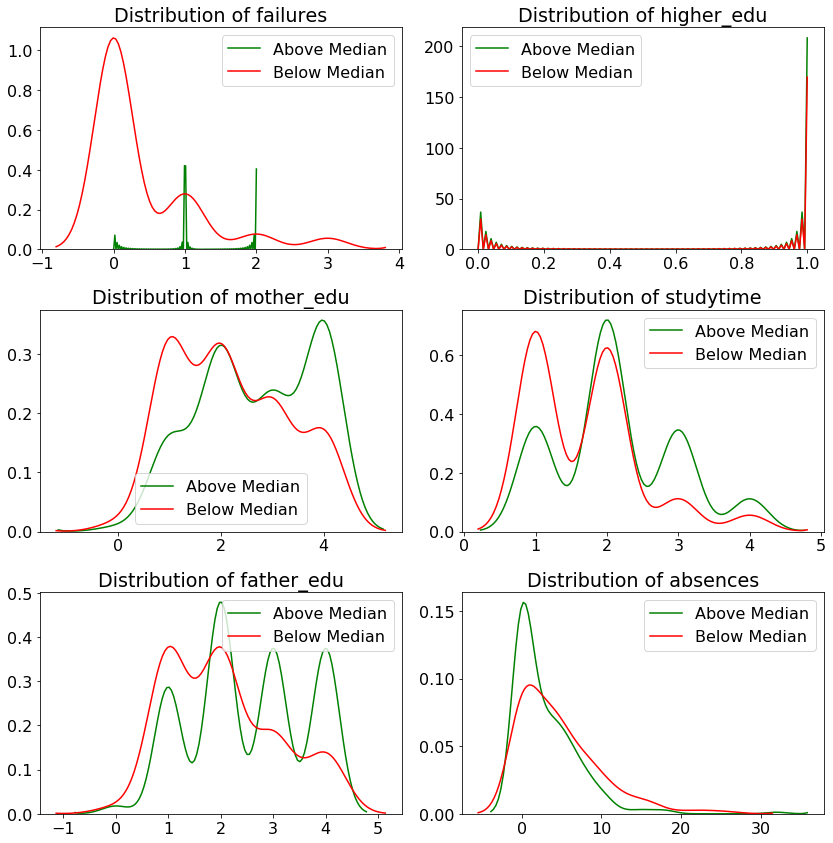

In [36]:
plt.figure(figsize=(12, 12))
# Plot the distribution of each variable colored
# by the relation to the median grade
for i, col in enumerate(X_plot.columns[:-1]):
    plt.subplot(3, 2, i + 1)
    subset_above = X_plot[X_plot['relation_median'] == 'above']
    subset_below = X_plot[X_plot['relation_median'] == 'below']
    sns.kdeplot(subset_above[col], label = 'Above Median', color = 'green')
    sns.kdeplot(subset_below[col], label = 'Below Median', color = 'red')
    plt.legend(); plt.title('Distribution of %s' % col)
    
plt.tight_layout()

The green distributions represent students with grades at or above the median, and the red is students below. We can see that some variables are more positively correlated with grades (such as studytime), while others are indicators of low grades, such as low father_edu.

### Standard Machine Learning Models

In [37]:
# Evaluate several ml models by training on training set and testing on testing set
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    X_train = X_train.drop(columns='Grade')
    X_test = X_test.drop(columns='Grade')
    
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.ix[model_name, :] = [mae, rmse]
    
    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.ix['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

In [38]:
results = evaluate(X_train, X_test, y_train, y_test)

C:\Users\ashupatel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
C:\Users\ashupatel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
C:\Users\ashupatel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
C:\Users\ashu

#### Visual Comparison of Models

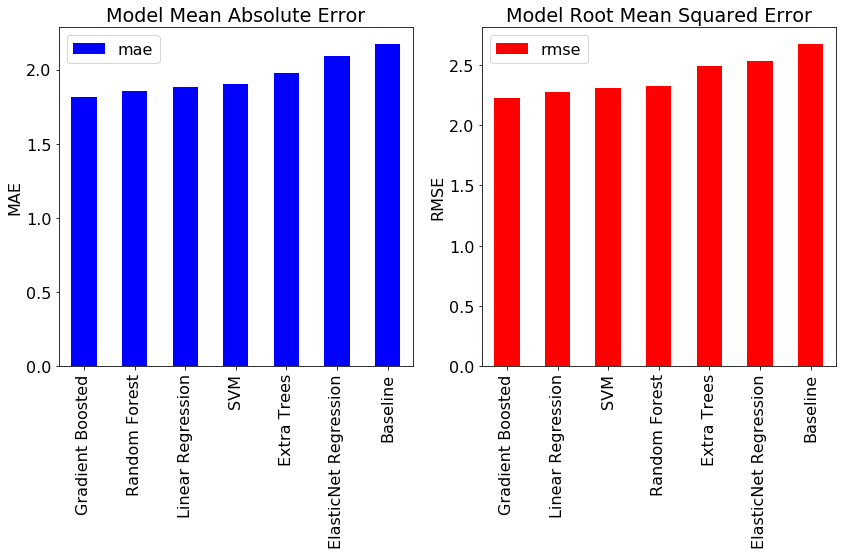

In [39]:
figsize(12, 8)
matplotlib.rcParams['font.size'] = 16
# Root mean squared error
ax =  plt.subplot(1, 2, 1)
results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'b', ax = ax)
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')

# Median absolute percentage error
ax = plt.subplot(1, 2, 2)
results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'r', ax = ax)
plt.title('Model Root Mean Squared Error')
plt.ylabel('RMSE');

plt.tight_layout()

In [40]:
results

,mae,rmse
Linear Regression,1.8859,2.27395
ElasticNet Regression,2.09282,2.53656
Random Forest,1.85529,2.32467
Extra Trees,1.97657,2.4871
SVM,1.90262,2.30825
Gradient Boosted,1.81272,2.22737
Baseline,2.1761,2.67765


In [41]:
print('The Gradient Boosted regressor is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Gradient Boosted', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))

The Gradient Boosted regressor is 16.70% better than the baseline.


### Formula from Ordinary Least Squares Linear Regression

In [42]:
lr = LinearRegression()
lr.fit(X_train.drop(columns='Grade'), y_train)

ols_formula = 'Grade = %0.2f +' % lr.intercept_
for i, col in enumerate(X_train.columns[1:]):
    ols_formula += ' %0.2f * %s +' % (lr.coef_[i], col)
    
' '.join(ols_formula.split(' ')[:-1])

'Grade = 9.19 + -1.32 * failures + 1.86 * higher_edu + 0.26 * mother_edu + 0.58 * studytime + 0.03 * father_edu + -0.07 * absences'

In [44]:
print('The Gradient Boosted regressor is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Gradient Boosted', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))

The Gradient Boosted regressor is 16.70% better than the baseline.


## Part 2

In Bayesian Linear Regression assumes the responses are sampled from a probability distribution such as the normal (Gaussian) distribution.

The mean of the Gaussian is the product of the parameters, β and the inputs, X, and the standard deviation is σ. In Bayesian Models, not only is the response assumed to be sampled from a distribution, but so are the parameters. The objective is to determine the posterior probability distribution for the model parameters given the inputs, X, and outputs, y.

The posterior is equal to the likelihood of the data times the prior for the model parameters divided by a normalization constant. If we have some domain knowledge, we can use it to assign priors for the model parameters, or we can use non-informative priors.

In practice, calculating the exact posterior distribution is computationally intractable for continuous values and so we turn to sampling methods such as Markov Chain Monte Carlo (MCMC) to draw samples from the posterior in order to approximate the posterior. Monte Carlo refers to the general technique of drawing random samples, and Markov Chain means the next sample drawn is based only on the previous sample value. The concept is that as we draw more samples, the approximation of the posterior will eventually converge on the true posterior distribution for the model parameters.

The end result of Bayesian Linear Modeling is not a single estimate for the model parameters, but a distribution that we can use to make inferences about new observations. This distribution allows us to demonstrate our uncertainty in the model and is one of the benefits of Bayesian Modeling methods. As the number of data points increases, the uncertainty should decrease, showing a higher level of certainty in our estimates.

There are only two steps we need to do to perform Bayesian Linear Regression with this module:
1. Build a formula relating the features to the target and decide on a prior distribution for the data likelihood
2. Sample from the parameter posterior distribution using MCMC

### Implementing Bayesian Linear Regression

In [45]:
#  Formula for Bayesian Linear Regression (follows R formula syntax
formula = 'Grade ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
formula

'Grade ~ failures + higher_edu + mother_edu + studytime + father_edu + absences'

#### Create Model in PyMC3 and Sample from Posterior
We now build the model using the formula defined above and a normal distribution for the data likelihood. Then, we let a Markov Chain Monte Carlo algorithm draw samples from the posterior to approximate the posterior for each of the model parameters.

In [49]:
# Context for the model
with pm.Model() as normal_model:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = X_train, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, absences, father_edu, studytime, mother_edu, higher_edu, failures, Intercept]

Sampling 2 chains, 0 divergences:   3%|█▍                                      | 173/5000 [01:32<1:55:59,  1.44s/draws]


Sampling 2 chains, 0 divergences:   6%|██▋                                       | 323/5000 [03:15<59:55,  1.30draws/s]


Sampling 2 chains, 0 divergences:  10%|███▉                                      | 476/5000 [04:35<38:09,  1.98draws/s]


Sampling 2 chains, 0 divergences:  12%|█████▏                                    | 623/5000 [05:26<23:20,  3.12draws/s]


Sampling 2 chains, 0 divergences:  16%|██████▌                                   | 782/5000 [06:23<26:50,  2.62draws/s]


Sampling 2 chains, 0 divergences:  19%|███████▉                                  | 940/5000 [07:13<21:24,  3.16draws/s]


Sampling 2 chains, 0 divergences:  22%|█████████                                | 1098/5000 [08:06<25:04,  2.59draws/s]


Sampling 2 chains, 0 divergences:  25%|██████████▎                              | 1263/5000 [09:04<19:42,  3.16draws/s]


Sampling 2 chains, 0 divergences:  28%|███████████▋                             | 1420/5000 [10:04<18:54,  3.15draws/s]


Sampling 2 chains, 0 divergences:  31%|████████████▉                            | 1574/5000 [10:59<25:57,  2.20draws/s]


Sampling 2 chains, 0 divergences:  35%|██████████████▏                          | 1732/5000 [11:54<25:03,  2.17draws/s]


Sampling 2 chains, 0 divergences:  38%|███████████████▍                         | 1880/5000 [12:46<14:54,  3.49draws/s]


Sampling 2 chains, 0 divergences:  41%|████████████████▋                        | 2028/5000 [13:39<17:51,  2.77draws/s]


Sampling 2 chains, 0 divergences:  44%|█████████████████▉                       | 2183/5000 [14:34<17:02,  2.75draws/s]


Sampling 2 chains, 0 divergences:  46%|███████████████████                      | 2324/5000 [15:25<12:15,  3.64draws/s]


Sampling 2 chains, 0 divergences:  50%|████████████████████▎                    | 2479/5000 [16:21<15:28,  2.71draws/s]


Sampling 2 chains, 0 divergences:  53%|█████████████████████▌                   | 2630/5000 [17:24<13:33,  2.91draws/s]


Sampling 2 chains, 0 divergences:  56%|██████████████████████▉                  | 2791/5000 [18:19<13:58,  2.63draws/s]


Sampling 2 chains, 0 divergences:  59%|████████████████████████▎                | 2961/5000 [19:17<13:32,  2.51draws/s]


Sampling 2 chains, 0 divergences:  62%|█████████████████████████▌               | 3115/5000 [20:13<16:52,  1.86draws/s]


Sampling 2 chains, 0 divergences:  65%|██████████████████████████▊              | 3271/5000 [21:12<11:59,  2.40draws/s]


Sampling 2 chains, 0 divergences:  68%|████████████████████████████             | 3422/5000 [22:04<10:42,  2.46draws/s]


Sampling 2 chains, 0 divergences:  72%|█████████████████████████████▍           | 3585/5000 [23:05<11:15,  2.10draws/s]


Sampling 2 chains, 0 divergences:  75%|██████████████████████████████▋          | 3748/5000 [24:04<08:34,  2.43draws/s]


Sampling 2 chains, 0 divergences:  78%|███████████████████████████████▉         | 3902/5000 [24:59<06:08,  2.98draws/s]


Sampling 2 chains, 0 divergences:  81%|█████████████████████████████████▎       | 4064/5000 [25:58<06:44,  2.32draws/s]


Sampling 2 chains, 0 divergences:  84%|██████████████████████████████████▌      | 4219/5000 [26:53<05:16,  2.47draws/s]


Sampling 2 chains, 0 divergences:  88%|███████████████████████████████████▉     | 4379/5000 [27:48<04:15,  2.43draws/s]


Sampling 2 chains, 0 divergences:  91%|█████████████████████████████████████▏   | 4532/5000 [28:41<02:43,  2.86draws/s]


Sampling 2 chains, 0 divergences:  94%|██████████████████████████████████████▎  | 4676/5000 [29:35<02:02,  2.65draws/s]


Sampling 2 chains, 0 divergences:  96%|███████████████████████████████████████▌ | 4823/5000 [30:28<01:09,  2.55draws/s]


Sampling 2 chains, 0 divergences:  99%|████████████████████████████████████████▊| 4970/5000 [31:34<00:16,  1.84draws/s]


Sampling 2 chains, 0 divergences: 100%|█████████████████████████████████████████| 5000/5000 [31:53<00:00,  2.61draws/s]


### Examine Bayesian Linear Regression Results
#### Traceplot of All Samples

In [56]:
# Shows the trace with a vertical line at the mean of the trace
def plot_trace(trace):
    # Traceplot with vertical lines at the mean value
    ax = pm.traceplot(trace, figsize=(14, len(trace.varnames)*1.8),
                      lines={k: v['mean'] for k, v in pm.summary(trace).iterrows()})
    
    matplotlib.rcParams['font.size'] = 16
    
    # Labels with the median value
    for i, mn in enumerate(pm.summary(trace)['mean']):
        ax[i, 0].annotate('{:0.2f}'.format(mn), xy = (mn, 0), xycoords = 'data', size = 8,
                          xytext = (-18, 18), textcoords = 'offset points', rotation = 90,
                          va = 'bottom', fontsize = 'large', color = 'red')

C:\Users\ashupatel\AppData\Local\Continuum\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\traceplot.py:143: UserWarning: A valid var_name should be provided, found {'I', 'm', 'f', 'h', 's', 'a'} expected from {'higher_edu', 'sd', 'studytime', 'absences', 'failures', 'father_edu', 'Intercept', 'mother_edu'}
  invalid_var_names, all_var_names


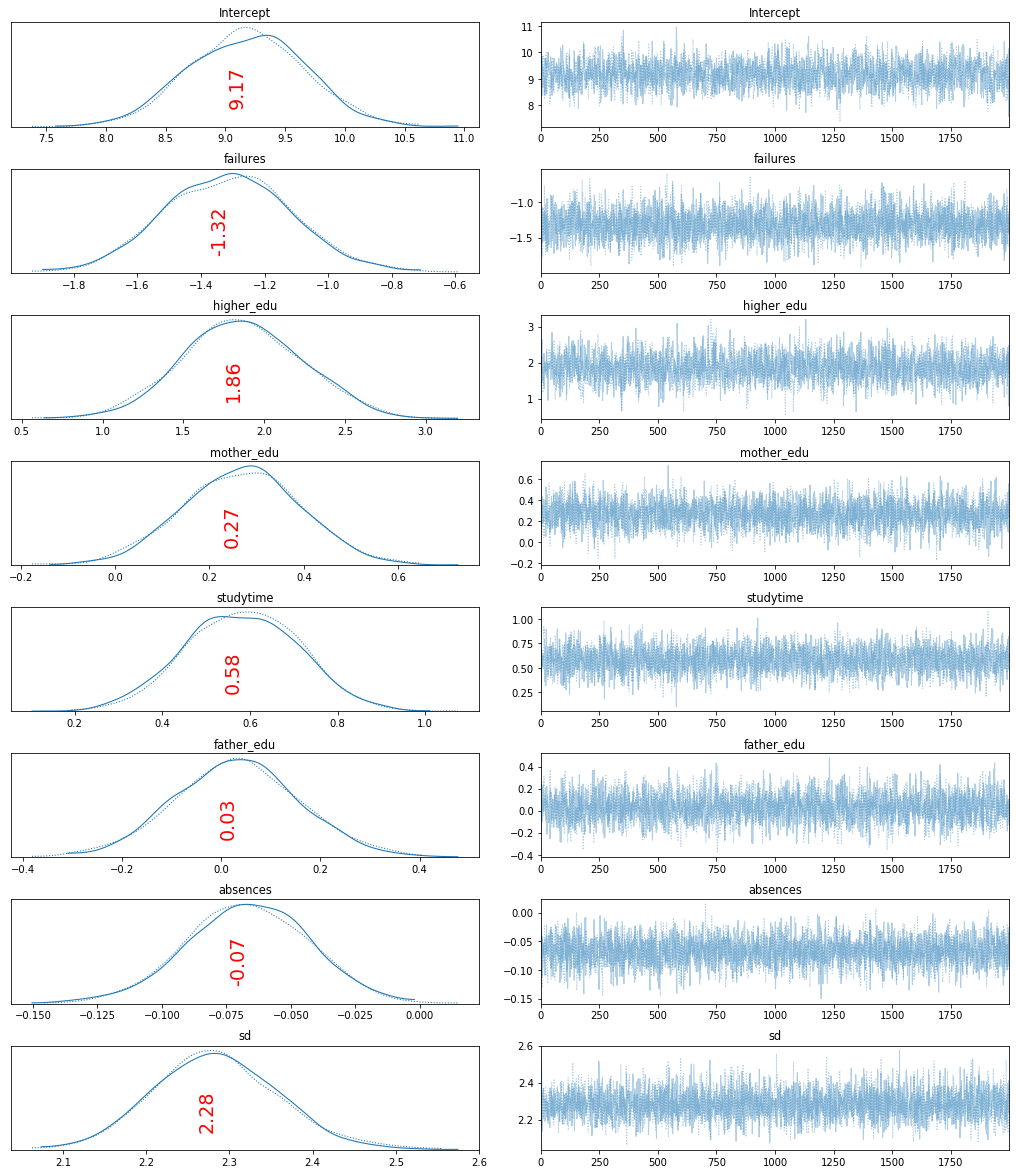

In [57]:
plot_trace(normal_trace)

The left side of the traceplot is the marginal posterior: the values for the variable are on the x-axis with the probability for the variable (as determined by sampling) on the y-axis. The different colored lines indicate that we performed two chains of Markov Chain Monte Carlo. From the left side we can see that there is a range of values for each weight. The right side shows the different sample values drawn as the sampling process runs.

Another method built into PyMC3 for examinig trace results is the forestplot which shows the distribution of each sampled parameter. This allows us to see the uncertainty in each sample. The forestplot is easily constructed from the trace using pm.forestplot.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000218D5EE2AC8>],
      dtype=object)

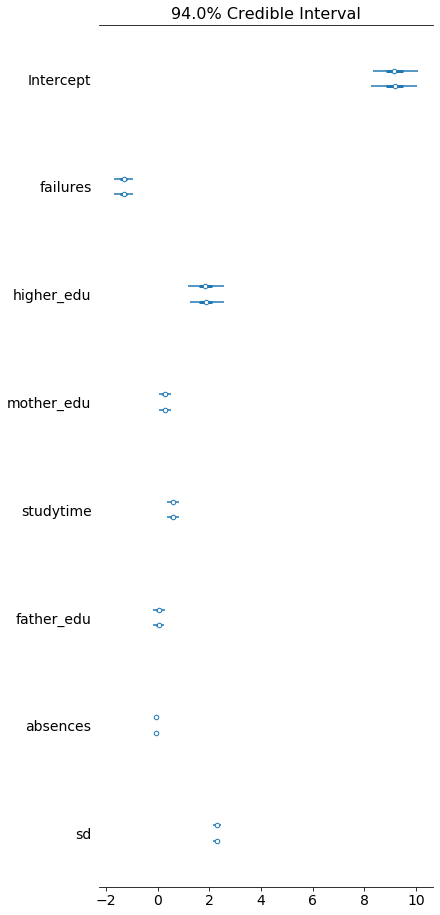

In [58]:
pm.forestplot(normal_trace)

From the forest plot we can see the most likely value of the parameter (the dot) as well as the 95% credible interval for the parameter. The intercept and higher_edu have larger uncertainty compared to the other variables.

Another built in plotting method in PyMC3 is the posterior distribution of all the model parameters. These histograms allow us to see how the model result is a distribution for the parameters rather than a single value.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000218D5EB4848>,
      dtype=object)

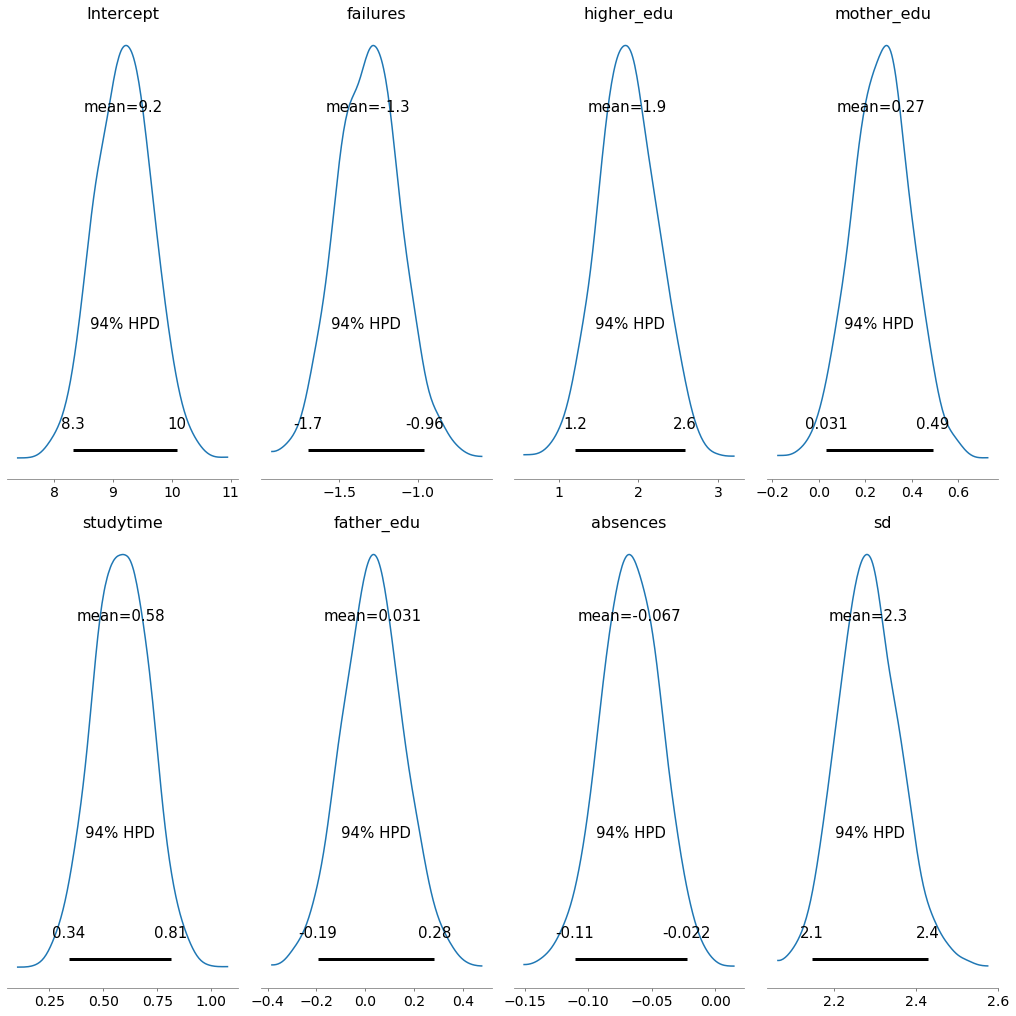

In [78]:
pm.plot_posterior(normal_trace, figsize = (14, 14))

Here we can see the mean, which we can use as most likely estimate, and also the entire distribution. 95% HPD stands for the 95% Highest Posterior Density and is a credible interval for our parameters. A credible interval is the Bayesian equivalent of a confidence interval in Frequentist statistics

In [60]:
# Print out the mean variable weight from the trace
for variable in normal_trace.varnames:
    print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, 
                                                                np.mean(normal_trace[variable])))

Variable: Intercept       Mean weight in model: 9.1742
Variable: failures        Mean weight in model: -1.3158
Variable: higher_edu      Mean weight in model: 1.8599
Variable: mother_edu      Mean weight in model: 0.2669
Variable: studytime       Mean weight in model: 0.5811
Variable: father_edu      Mean weight in model: 0.0306
Variable: absences        Mean weight in model: -0.0672
Variable: sd_log__        Mean weight in model: 0.8253
Variable: sd              Mean weight in model: 2.2838


#### Interpretations of Weights
Based on the sign and location of the weights, we can make the following inferences regarding the features in our dataset:

* Previous class failures are negatively related to the students final grade
* Higher education ambitions are positively related to the students grade
* The mother's and father's education levels are positively related to the students final grade
* Studying time per week is positively related to the students final grade
* Absences are negatively related to the students final grade

In [61]:
pm.summary(normal_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,9.174,0.476,8.322,10.081,0.011,0.008,1893.0,1885.0,1884.0,2396.0,1.0
failures,-1.316,0.200,-1.699,-0.959,0.003,0.002,3398.0,3372.0,3403.0,2797.0,1.0
higher_edu,1.860,0.370,1.204,2.580,0.008,0.005,2399.0,2399.0,2400.0,2457.0,1.0
mother_edu,0.267,0.124,0.031,0.491,0.002,0.002,2887.0,2538.0,2870.0,2648.0,1.0
studytime,0.581,0.128,0.340,0.813,0.002,0.002,2900.0,2879.0,2885.0,2631.0,1.0
father_edu,0.031,0.126,-0.193,0.283,0.002,0.002,2741.0,1904.0,2742.0,2417.0,1.0
absences,-0.067,0.024,-0.111,-0.022,0.000,0.000,3657.0,3438.0,3678.0,2978.0,1.0
sd,2.284,0.075,2.146,2.428,0.001,0.001,3598.0,3591.0,3612.0,2221.0,1.0


#### Linear Formula from Bayesian Inference using Mean of Parameters

In [62]:
model_formula = 'Grade = '
for variable in normal_trace.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(normal_trace[variable]), variable)

' '.join(model_formula.split(' ')[:-1])

'Grade =  9.17 * Intercept + -1.32 * failures + 1.86 * higher_edu + 0.27 * mother_edu + 0.58 * studytime + 0.03 * father_edu + -0.07 * absences + 0.83 * sd_log__ + 2.28 * sd'

### Evaluate Bayesian Model Using Mean of Model Parameters

In [63]:
# Evalute the MCMC trace and compare to ml models
def evaluate_trace(trace, X_train, X_test, y_train, y_test, model_results):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Means for all the weights
    var_means = var_weights.mean(axis=0)
    
    # Create an intercept column
    X_test['Intercept'] = 1
    
    # Align names of the test observations and means
    names = X_test.columns[1:]
    X_test = X_test.ix[:, names]
    var_means = var_means[names]
    
    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        results.ix[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
        
    # Metrics 
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    mae = np.mean(abs(errors))
    rmse = np.sqrt(np.mean(errors ** 2))
    
    print('Model  MAE: {:.4f}\nModel RMSE: {:.4f}'.format(mae, rmse))
    
    # Add the results to the comparison dataframe
    model_results.ix['Bayesian LR', :] = [mae, rmse]
    
    plt.figure(figsize=(12, 8))
    
    # Plot median absolute percentage error of all models
    ax = plt.subplot(1, 2, 1)
    model_results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'r', ax = ax)
    plt.title('Model Mean Absolute Error Comparison'); plt.ylabel('MAE'); 
    plt.tight_layout()
    
    # Plot root mean squared error of all models
    ax = plt.subplot(1, 2, 2)
    model_results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'b', ax = ax)
    plt.title('Model RMSE Comparison'); plt.ylabel('RMSE')
    
    return model_results

C:\Users\ashupatel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
C:\Users\ashupatel\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)
C:\Users\ashupatel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/st

Model  MAE: 1.8856
Model RMSE: 2.2737


C:\Users\ashupatel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


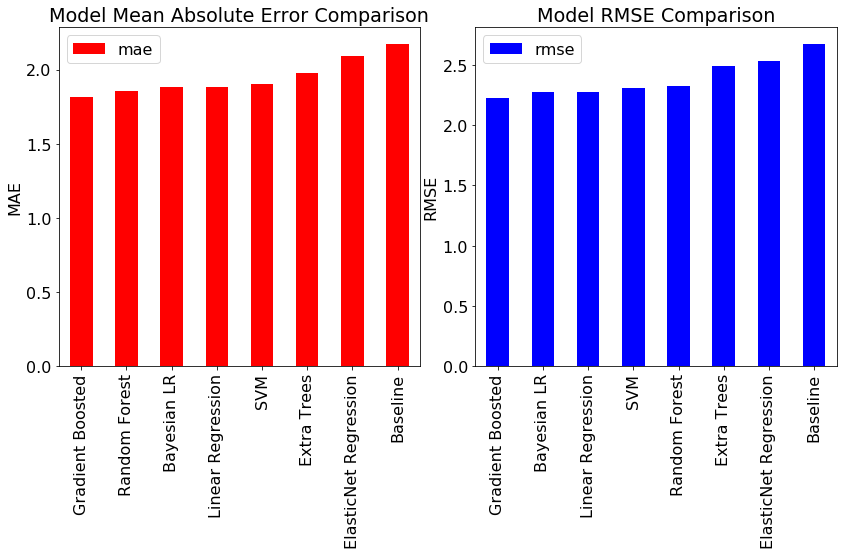

In [64]:
all_model_results = evaluate_trace(normal_trace, X_train, X_test, y_train, y_test, results)

In [65]:
all_model_results

,mae,rmse
Linear Regression,1.8859,2.27395
ElasticNet Regression,2.09282,2.53656
Random Forest,1.85529,2.32467
Extra Trees,1.97657,2.4871
SVM,1.90262,2.30825
Gradient Boosted,1.81272,2.22737
Baseline,2.1761,2.67765
Bayesian LR,1.88562,2.27366


### Make Predictions from Model
#### Test Observations

In [66]:
# Make a new prediction from the test set and compare to actual value
def test_model(trace, test_observation):
    
    # Print out the test observation data
    print('Test Observation:')
    print(test_observation)
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]

    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Standard deviation of the likelihood
    sd_value = var_weights['sd'].mean()

    # Actual Value
    actual = test_observation['Grade']
    
    # Add in intercept term
    test_observation['Intercept'] = 1
    test_observation = test_observation.drop('Grade')
    
    # Align weights and test observation
    var_weights = var_weights[test_observation.index]

    # Means for all the weights
    var_means = var_weights.mean(axis=0)

    # Location of mean for observation
    mean_loc = np.dot(var_means, test_observation)
    
    # Estimates of grade
    estimates = np.random.normal(loc = mean_loc, scale = sd_value,
                                 size = 1000)

    # Plot all the estimates
    plt.figure(figsize(8, 8))
    sns.distplot(estimates, hist = True, kde = True, bins = 19,
                 hist_kws = {'edgecolor': 'k', 'color': 'darkblue'},
                kde_kws = {'linewidth' : 4},
                label = 'Estimated Dist.')
    # Plot the actual grade
    plt.vlines(x = actual, ymin = 0, ymax = 5, 
               linestyles = '--', colors = 'red',
               label = 'True Grade',
              linewidth = 2.5)
    
    # Plot the mean estimate
    plt.vlines(x = mean_loc, ymin = 0, ymax = 5, 
               linestyles = '-', colors = 'orange',
               label = 'Mean Estimate',
              linewidth = 2.5)
    
    plt.legend(loc = 1)
    plt.title('Density Plot for Test Observation');
    plt.xlabel('Grade'); plt.ylabel('Density');
    
    # Prediction information
    print('True Grade = %d' % actual)
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

Test Observation:
Grade         12
failures       0
higher_edu     1
mother_edu     2
studytime      1
father_edu     2
absences       8
Intercept      1
Name: 39, dtype: int64


C:\Users\ashupatel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


True Grade = 12
Average Estimate = 11.6730
5% Estimate = 7.8223    95% Estimate = 15.4695


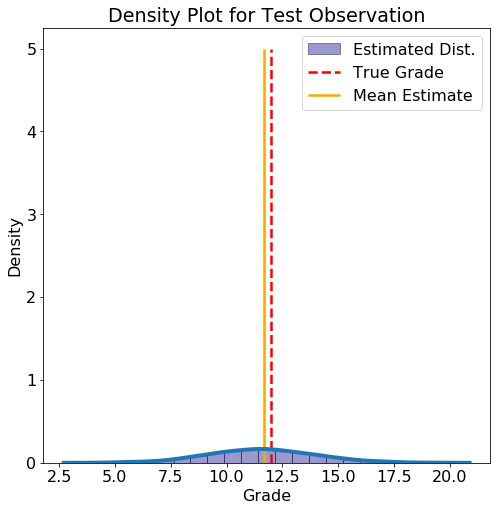

In [67]:
test_model(normal_trace, X_test.iloc[41])

Test Observation:
Grade         12
failures       0
higher_edu     1
mother_edu     1
studytime      2
father_edu     1
absences       6
Intercept      1
Name: 2, dtype: int64


C:\Users\ashupatel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


True Grade = 12
Average Estimate = 12.0909
5% Estimate = 8.6346    95% Estimate = 15.9421


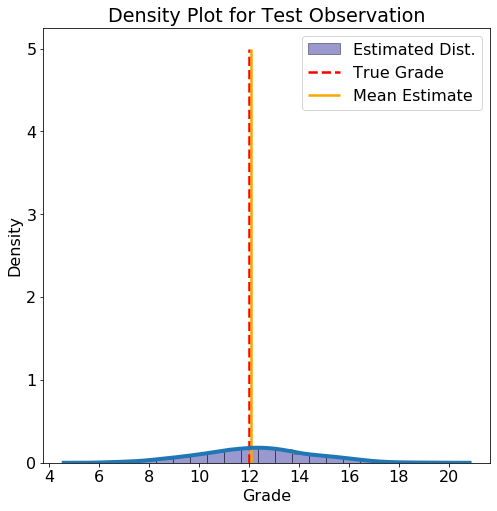

In [68]:
test_model(normal_trace, X_test.iloc[16])

#### Predictions for New Observation

In [69]:
# Make predictions for a new data point from the model trace
def query_model(trace, new_observation):
    
    # Print information about the new observation
    print('New Observation')
    print(new_observation)
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Standard deviation
    sd_value = var_dict['sd'].mean()
    
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Align weights and new observation
    var_weights = var_weights[new_observation.index]
    
    # Means of variables
    var_means = var_weights.mean(axis=0)
    
    # Mean for observation
    mean_loc = np.dot(var_means, new_observation)
    
    # Distribution of estimates
    estimates = np.random.normal(loc = mean_loc, scale = sd_value,
                                 size = 1000)
    
    # Plot the estimate distribution
    plt.figure(figsize(8, 8))
    sns.distplot(estimates, hist = True, kde = True, bins = 19,
                 hist_kws = {'edgecolor': 'k', 'color': 'darkblue'},
                kde_kws = {'linewidth' : 4},
                label = 'Estimated Dist.')
    # Plot the mean estimate
    plt.vlines(x = mean_loc, ymin = 0, ymax = 5, 
               linestyles = '-', colors = 'orange', linewidth = 2.5)
    plt.title('Density Plot for New Observation');
    plt.xlabel('Grade'); plt.ylabel('Density');
    
    # Estimate information
    print('Average Estimate = %0.4f' % mean_loc)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

New Observation
Intercept     1
mother_edu    4
failures      0
higher_edu    1
studytime     3
father_edu    1
absences      1
dtype: int64
Average Estimate = 13.8086
5% Estimate = 10.1175    95% Estimate = 17.4793


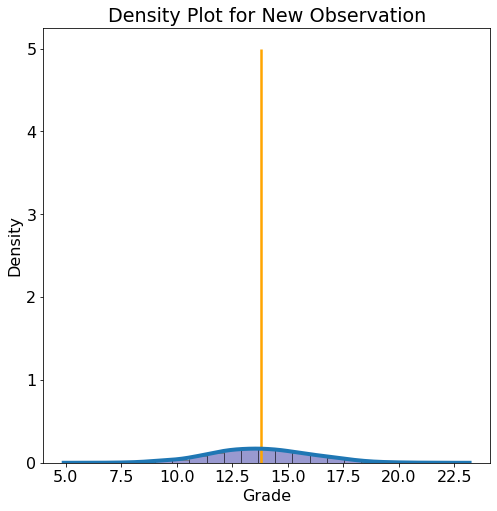

In [70]:
observation = pd.Series({'Intercept': 1, 'mother_edu': 4, 'failures': 0, 
                            'higher_edu': 1, 'studytime': 3,
                            'father_edu': 1, 'absences': 1})
query_model(normal_trace, observation)

New Observation
Intercept     1
mother_edu    2
failures      2
higher_edu    1
studytime     2
father_edu    3
absences      4
dtype: int64
Average Estimate = 9.9218
5% Estimate = 6.3114    95% Estimate = 13.8306


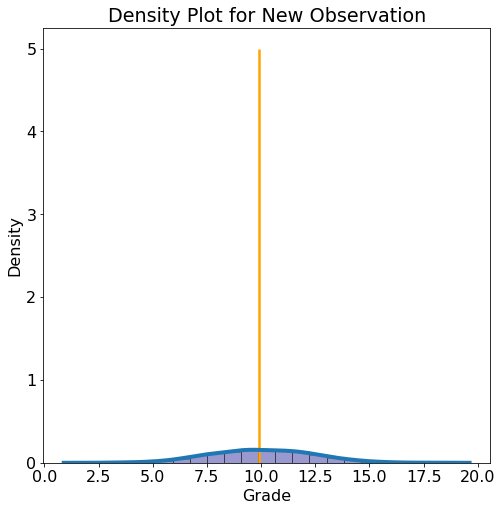

In [71]:
observation = pd.Series({'Intercept': 1, 'mother_edu': 2, 'failures': 2, 
                            'higher_edu': 1, 'studytime': 2,
                            'father_edu': 3, 'absences': 4})
query_model(normal_trace, observation)

### Model Variable Effects
If we want to see the effect of changing one variable while holding the others constant, we can use the function pm.plot_posterior_predictive_glm. This takes a range of values to use for the variable, a linear model, and a number of samples. The function evaluates the linear model across the range of values for the number of samples. Each time, it draws a different set of parameters from the trace. This gives us an indication of the effect of a single variable and also the uncertainty in the model estimates. To see the effect of a single variable, we hold the others constant at their median values.

In [72]:
# Examines the effect of changing a single variable
# Takes in the name of the variable, the trace, and the data
def model_effect(query_var, trace, X):
    
    # Variables that do not change
    steady_vars = list(X.columns)
    steady_vars.remove(query_var)
    
    # Linear Model that estimates a grade based on the value of the query variable 
    # and one sample from the trace
    def lm(value, sample):
        
        # Prediction is the estimate given a value of the query variable
        prediction = sample['Intercept'] + sample[query_var] * value
        
        # Each non-query variable is assumed to be at the median value
        for var in steady_vars:
            
            # Multiply the weight by the median value of the variable
            prediction += sample[var] * X[var].median()
        
        return prediction
    
    figsize(6, 6)
    
    # Find the minimum and maximum values for the range of the query var
    var_min = X[query_var].min()
    var_max = X[query_var].max()
    
    # Plot the estimated grade versus the range of query variable
    pm.plot_posterior_predictive_glm(trace, eval=np.linspace(var_min, var_max, 100), 
                                     lm=lm, samples=100, color='blue', 
                                     alpha = 0.4, lw = 2)
    
    # Plot formatting
    plt.xlabel('%s' % query_var, size = 16)
    plt.ylabel('Grade', size = 16)
    plt.title("Posterior of Grade vs %s" % query_var, size = 18)
    plt.show()

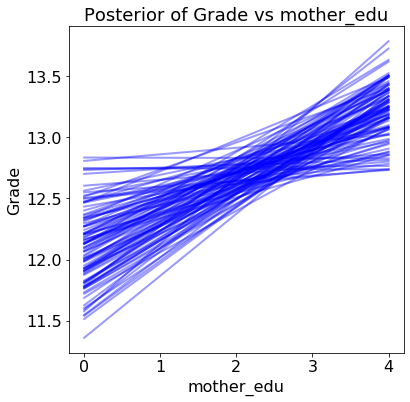

In [73]:
model_effect('mother_edu', normal_trace, X_train.drop(columns='Grade'))

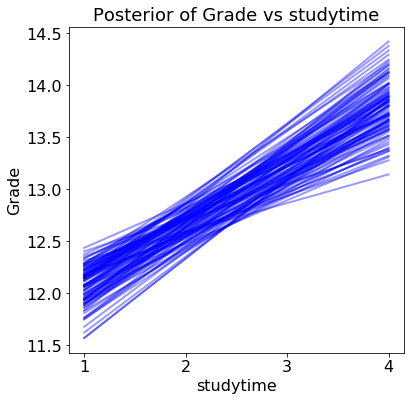

In [74]:
model_effect('studytime', normal_trace, X_train.drop(columns='Grade'))

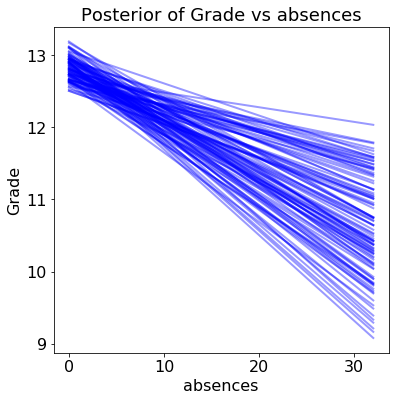

In [75]:
model_effect('absences', normal_trace, X_train.drop(columns='Grade'))

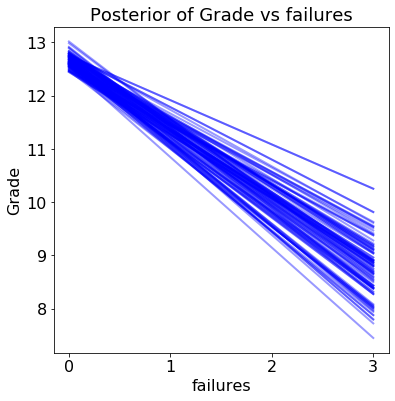

In [76]:
model_effect('failures', normal_trace, X_train.drop(columns='Grade'))

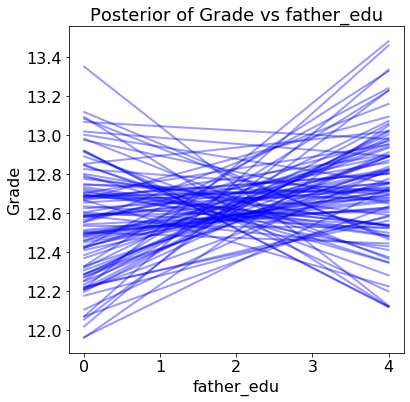

In [77]:
model_effect('father_edu', normal_trace, X_train.drop(columns='Grade'))

reference
https://towardsdatascience.com/bayesian-linear-regression-in-python-using-machine-learning-to-predict-student-grades-part-2-b72059a8ac7e